In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e24/sample_submission.csv
/kaggle/input/playground-series-s3e24/train.csv
/kaggle/input/playground-series-s3e24/test.csv


In [2]:
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_validate, GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score, log_loss
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline

# Data import and a little insight

In [3]:
train_df = pd.read_csv("/kaggle/input/playground-series-s3e24/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s3e24/test.csv")

In [4]:
test_id = test_df["id"]

In [5]:
train_df

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55,165,60,81.0,0.5,0.6,1,1,135,...,40,75,16.5,1,1.0,22,25,27,0,1
1,1,70,165,65,89.0,0.6,0.7,2,2,146,...,57,126,16.2,1,1.1,27,23,37,1,0
2,2,20,170,75,81.0,0.4,0.5,1,1,118,...,45,93,17.4,1,0.8,27,31,53,0,1
3,3,35,180,95,105.0,1.5,1.2,1,1,131,...,38,102,15.9,1,1.0,20,27,30,1,0
4,4,30,165,60,80.5,1.5,1.0,1,1,121,...,44,93,15.4,1,0.8,19,13,17,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159251,159251,40,155,45,69.0,1.5,2.0,1,1,127,...,72,159,14.5,1,0.8,25,26,13,0,0
159252,159252,50,155,75,82.0,1.0,1.0,1,1,120,...,64,108,14.5,1,0.6,21,20,18,0,0
159253,159253,40,160,50,66.0,1.5,1.0,1,1,114,...,87,93,10.9,1,0.6,15,9,12,0,0
159254,159254,50,165,75,92.0,1.2,1.0,1,1,121,...,55,80,14.4,1,1.1,22,17,37,0,1


In [6]:
train_df.describe()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
count,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,...,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000
mean,79627.500000,44.306626,165.266929,67.143662,83.001990,1.005798,1.000989,1.023974,1.023421,122.503648,...,55.852684,114.607682,14.796965,1.074233,0.892764,25.516853,26.550296,36.216004,0.197996,0.437365
std,45973.391572,11.842286,8.818970,12.586198,8.957937,0.402113,0.392299,0.152969,0.151238,12.729315,...,13.964141,28.158931,1.431213,0.347856,0.179346,9.464882,17.753070,31.204643,0.398490,0.496063
min,0.000000,20.000000,135.000000,30.000000,51.000000,0.100000,0.100000,1.000000,1.000000,77.000000,...,9.000000,1.000000,4.900000,1.000000,0.100000,6.000000,1.000000,2.000000,0.000000,0.000000
25%,39813.750000,40.000000,160.000000,60.000000,77.000000,0.800000,0.800000,1.000000,1.000000,114.000000,...,45.000000,95.000000,13.800000,1.000000,0.800000,20.000000,16.000000,18.000000,0.000000,0.000000
50%,79627.500000,40.000000,165.000000,65.000000,83.000000,1.000000,1.000000,1.000000,1.000000,121.000000,...,54.000000,114.000000,15.000000,1.000000,0.900000,24.000000,22.000000,27.000000,0.000000,0.000000
75%,119441.250000,55.000000,170.000000,75.000000,89.000000,1.200000,1.200000,1.000000,1.000000,130.000000,...,64.000000,133.000000,15.800000,1.000000,1.000000,29.000000,32.000000,44.000000,0.000000,1.000000
max,159255.000000,85.000000,190.000000,130.000000,127.000000,9.900000,9.900000,2.000000,2.000000,213.000000,...,136.000000,1860.000000,21.000000,6.000000,9.900000,778.000000,2914.000000,999.000000,1.000000,1.000000


In [7]:
train_df.columns

Index(['id', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'smoking'],
      dtype='object')

In [8]:
train_df.isnull().sum()

id                     0
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
dtype: int64

Normally (and with my personal experience), these features can tells if a person is smoking or not:

- Blood creatinine + urine protein (kidney diseases)
- Blood sugar + eyesight (diabetes)
- Systolic BP - high BP

To be sure, I'll need to run PCA on all 24 features.

In [9]:
def preprocessing(df):
    # Calculate BMI
#     df["BMI"] = df["weight(kg)"] / ((df["height(cm)"] / 100) ** 2)
    
#     # Calculate eGFR (for kidney disease)
#     df["eGFR"] = (140 - df["age"]) * df["weight(kg)"] / (72 * df["serum creatinine"])
    
    df = df.drop([
        "id",
#         "age",
#         "weight(kg)",
#         "height(cm)",
#         "serum creatinine"
    ], axis=1)
    
    return df

In [10]:
train_df = preprocessing(train_df)
test_df = preprocessing(test_df)

In [11]:
train_df

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,55,165,60,81.0,0.5,0.6,1,1,135,87,...,40,75,16.5,1,1.0,22,25,27,0,1
1,70,165,65,89.0,0.6,0.7,2,2,146,83,...,57,126,16.2,1,1.1,27,23,37,1,0
2,20,170,75,81.0,0.4,0.5,1,1,118,75,...,45,93,17.4,1,0.8,27,31,53,0,1
3,35,180,95,105.0,1.5,1.2,1,1,131,88,...,38,102,15.9,1,1.0,20,27,30,1,0
4,30,165,60,80.5,1.5,1.0,1,1,121,76,...,44,93,15.4,1,0.8,19,13,17,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159251,40,155,45,69.0,1.5,2.0,1,1,127,80,...,72,159,14.5,1,0.8,25,26,13,0,0
159252,50,155,75,82.0,1.0,1.0,1,1,120,80,...,64,108,14.5,1,0.6,21,20,18,0,0
159253,40,160,50,66.0,1.5,1.0,1,1,114,70,...,87,93,10.9,1,0.6,15,9,12,0,0
159254,50,165,75,92.0,1.2,1.0,1,1,121,90,...,55,80,14.4,1,1.1,22,17,37,0,1


In [12]:
# train_df["serum creatinine"].describe()

In [13]:
# train_df[(train_df["eGFR"] > 120) & (train_df["smoking"] == 1)]

In [14]:
# train_df["eGFR"].describe()

In [15]:
# train_df["serum creatinine"]

In [16]:
# train_df[train_df["smoking"] == 1].plot.scatter(x = "Urine protein", y = "serum creatinine")
# plt.show()

In [17]:
# train_df[train_df["smoking"] == 1].plot.scatter(x = "eGFR", y = "BMI")
# plt.plot()

In [18]:
train_X = train_df.drop(["smoking"], axis=1)
train_y = train_df["smoking"]

In [19]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
train_X_std = sc.fit_transform(train_X)

In [20]:
from sklearn.decomposition import PCA

In [21]:
pca = PCA()
train_X_PCA = pca.fit_transform(train_X_std)

In [22]:
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

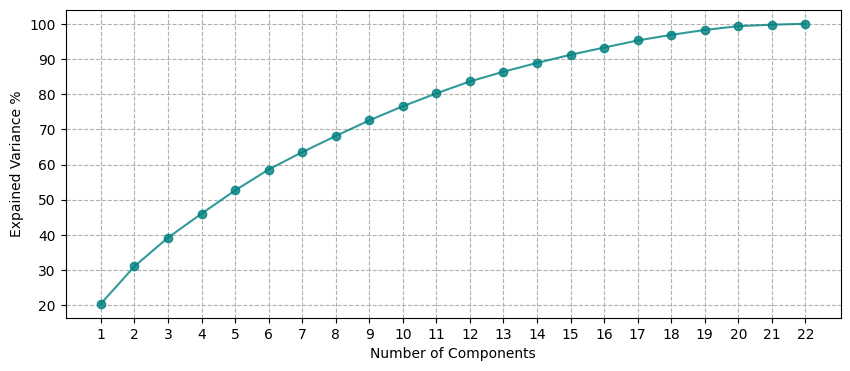

In [23]:
fig = plt.figure(figsize = (10,4))
plt.plot(np.arange(1, train_X_std.shape[1]+1),100 * cum_sum_eigenvalues, marker = 'o',
         color = 'teal', alpha = .8)
plt.xticks(np.arange(1, train_X_std.shape[1]+1),np.arange(1, train_X_std.shape[1]+1))
plt.xlabel('Number of Components')
plt.ylabel('Expained Variance %')
plt.grid(linestyle = '--')

plt.show()

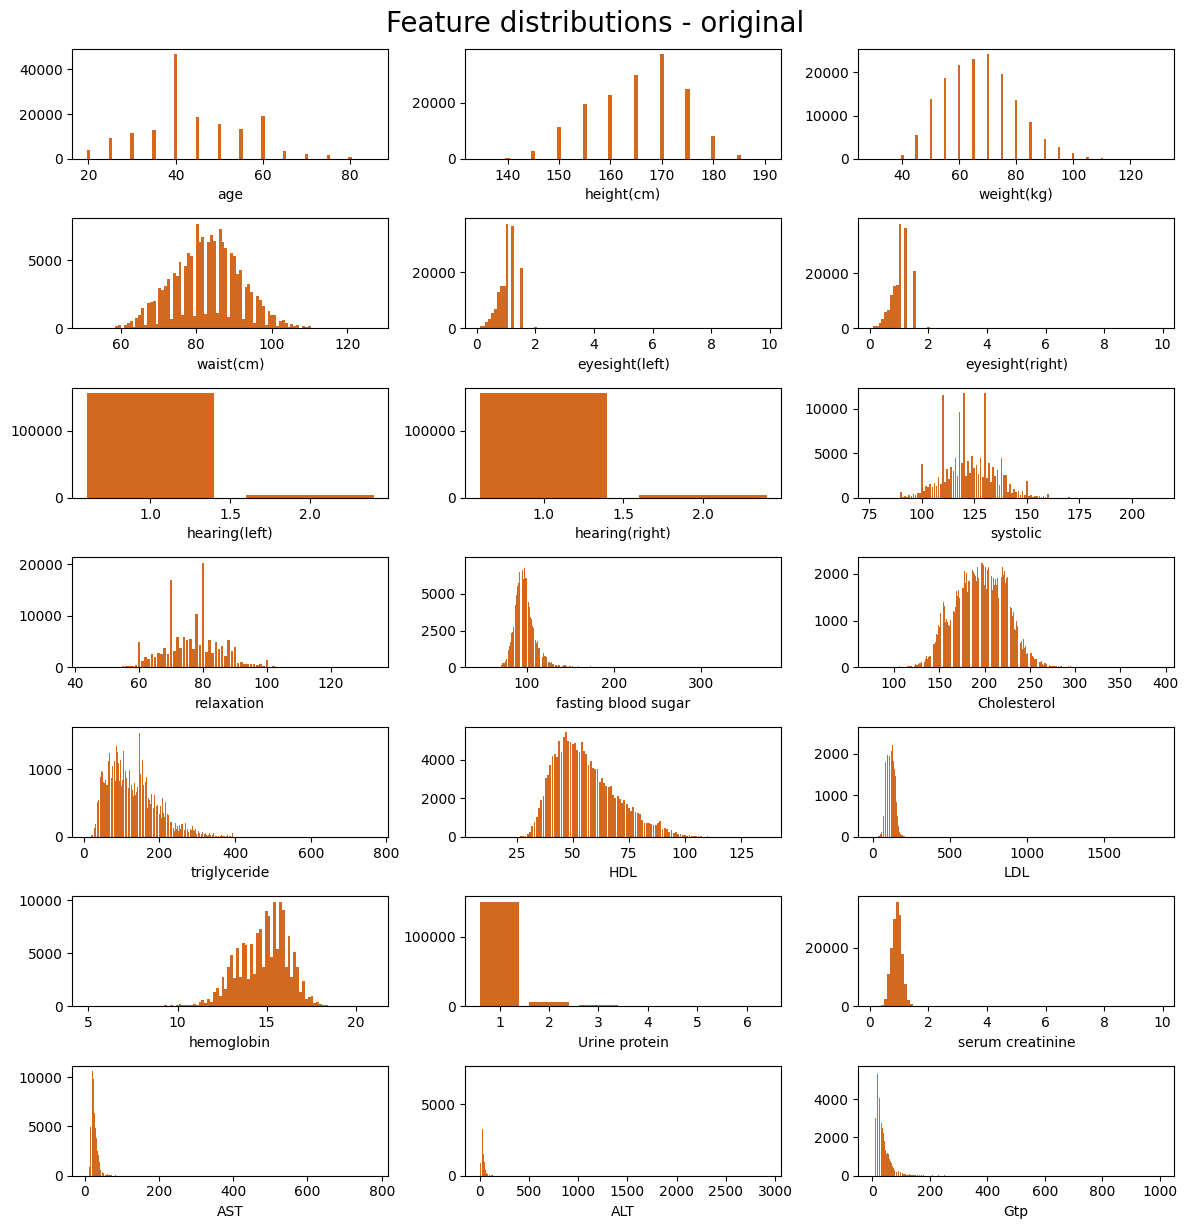

In [24]:
_, axs = plt.subplots(7, 3, figsize=(12, 12))
for col, ax in zip(train_X.columns, axs.ravel()):
    if train_X[col].dtype == float:
        ax.hist(train_X[col], bins=100, color='chocolate')
    else: #int
        vc = train_X[col].value_counts()
        ax.bar(vc.index, vc, color='chocolate')
    ax.set_xlabel(col)
plt.tight_layout()
plt.suptitle('Feature distributions - original', y=1.02, fontsize=20)
plt.show()

So the best option is to use all? True!

In [25]:
import seaborn as sns

In [26]:
estimators = [
    ("xgb", XGBClassifier(
        n_estimators=100
    )),
#     ("extree", ExtraTreesClassifier()),
    ("lgb", lgb.LGBMClassifier(
            min_child_samples=70,
            n_estimators=700
        )
    ),
#     ("gb", GradientBoostingClassifier()),
    ("cat", CatBoostClassifier(
            depth=6,
            l2_leaf_reg=4,
        )
    )
]

In [27]:
pipes = {}

for model in estimators:
    print(f"Fitting {model[0]}")
    
    pipe = Pipeline(steps=[
        ("std_scaler", StandardScaler()),
        model
    ])
    pipe.fit(train_X, train_y)
    pipes[pipe.steps[1][0]] = pipe

Fitting xgb
Fitting lgb
Fitting cat
0:	learn: 0.6775828	total: 88.9ms	remaining: 1m 28s
1:	learn: 0.6631892	total: 120ms	remaining: 59.7s
2:	learn: 0.6504113	total: 148ms	remaining: 49.1s
3:	learn: 0.6387169	total: 178ms	remaining: 44.3s
4:	learn: 0.6271965	total: 208ms	remaining: 41.3s
5:	learn: 0.6165554	total: 237ms	remaining: 39.2s
6:	learn: 0.6068780	total: 266ms	remaining: 37.8s
7:	learn: 0.5980372	total: 297ms	remaining: 36.9s
8:	learn: 0.5900725	total: 327ms	remaining: 36s
9:	learn: 0.5826498	total: 356ms	remaining: 35.3s
10:	learn: 0.5756714	total: 385ms	remaining: 34.6s
11:	learn: 0.5690858	total: 413ms	remaining: 34s
12:	learn: 0.5630450	total: 441ms	remaining: 33.5s
13:	learn: 0.5576091	total: 468ms	remaining: 33s
14:	learn: 0.5523002	total: 495ms	remaining: 32.5s
15:	learn: 0.5478586	total: 528ms	remaining: 32.5s
16:	learn: 0.5435420	total: 557ms	remaining: 32.2s
17:	learn: 0.5394431	total: 586ms	remaining: 32s
18:	learn: 0.5357638	total: 615ms	remaining: 31.8s
19:	learn: 

In [28]:
estimator_names = [model[0] for model in estimators]

In [29]:
def plot_estimators(estimators=estimator_names, 
                    X=train_X,
                    y=train_y,
                   n_splits=5,
                   metrics=["auc", "log_loss"]):
    metrics = {
        key: _metrics[key] for key in metrics
    }
    
    scorer, labels = [], []
    
    for pipe_name in pipes.keys():
        if pipe_name in estimators:
            pipe = pipes[pipe_name]
            
            print(pipe)
            
            labels.append(pipe_name)
            
            kf = KFold(n_splits)
            
            model_score = cross_validate(pipe, X, y, scoring=metrics, cv=kf, n_jobs=4)
            
            scorer.append(model_score)
    
    score_lists = {}
    
    for metric in metrics:
        score_lists[metric] = [score[f"test_{metric}"] for score in scorer]
        
    for i, (title, _list) in enumerate(score_lists.items()):
        plt.figure(i)
        plot = sns.boxplot(data=_list).set_xticklabels(labels, rotation=45)
        plt.title(title)

In [30]:
metrics = {
    "auc": make_scorer(roc_auc_score, needs_proba=True),
    "log_loss": make_scorer(log_loss)
}

_metrics = {
    "auc": make_scorer(roc_auc_score, needs_proba=True),
    "log_loss": make_scorer(log_loss)
}

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
  

TBB Warning: The number of workers is currently limited to 0. The request for 3 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.

TBB Warning: The number of workers is currently limited to 0. The request for 3 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.

TBB Warning: The number of workers is currently limited to 0. The request for 3 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



0:	learn: 0.6776658	total: 229ms	remaining: 3m 48s
1:	learn: 0.6632278	total: 433ms	remaining: 3m 36s
2:	learn: 0.6507289	total: 634ms	remaining: 3m 30s
3:	learn: 0.6385444	total: 840ms	remaining: 3m 29s
4:	learn: 0.6270412	total: 1.05s	remaining: 3m 28s
5:	learn: 0.6163848	total: 1.25s	remaining: 3m 26s
6:	learn: 0.6069512	total: 1.45s	remaining: 3m 25s
7:	learn: 0.5983684	total: 1.65s	remaining: 3m 24s
8:	learn: 0.5900878	total: 1.85s	remaining: 3m 23s
9:	learn: 0.5828367	total: 2.05s	remaining: 3m 23s
10:	learn: 0.5759398	total: 2.26s	remaining: 3m 23s
11:	learn: 0.5693568	total: 2.46s	remaining: 3m 22s
12:	learn: 0.5635525	total: 2.66s	remaining: 3m 21s
13:	learn: 0.5578385	total: 2.86s	remaining: 3m 21s
14:	learn: 0.5525988	total: 3.06s	remaining: 3m 20s
15:	learn: 0.5482883	total: 3.27s	remaining: 3m 21s
16:	learn: 0.5437684	total: 3.47s	remaining: 3m 20s
17:	learn: 0.5395752	total: 3.65s	remaining: 3m 19s
18:	learn: 0.5357736	total: 3.85s	remaining: 3m 19s
19:	learn: 0.5323368	t

TBB Warning: The number of workers is currently limited to 0. The request for 3 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



929:	learn: 0.4283211	total: 2m 46s	remaining: 12.5s
930:	learn: 0.4282959	total: 2m 46s	remaining: 12.4s
931:	learn: 0.4282737	total: 2m 46s	remaining: 12.2s
932:	learn: 0.4282479	total: 2m 47s	remaining: 12s
933:	learn: 0.4282471	total: 2m 47s	remaining: 11.8s
934:	learn: 0.4282207	total: 2m 47s	remaining: 11.6s
935:	learn: 0.4281989	total: 2m 47s	remaining: 11.5s
936:	learn: 0.4281784	total: 2m 47s	remaining: 11.3s
937:	learn: 0.4281588	total: 2m 47s	remaining: 11.1s
938:	learn: 0.4281335	total: 2m 48s	remaining: 10.9s
939:	learn: 0.4281071	total: 2m 48s	remaining: 10.7s
940:	learn: 0.4280855	total: 2m 48s	remaining: 10.6s
941:	learn: 0.4280570	total: 2m 48s	remaining: 10.4s
942:	learn: 0.4280397	total: 2m 48s	remaining: 10.2s
943:	learn: 0.4280190	total: 2m 49s	remaining: 10s
944:	learn: 0.4279970	total: 2m 49s	remaining: 9.85s
945:	learn: 0.4279738	total: 2m 49s	remaining: 9.67s
946:	learn: 0.4279572	total: 2m 49s	remaining: 9.49s
947:	learn: 0.4279307	total: 2m 49s	remaining: 9.3

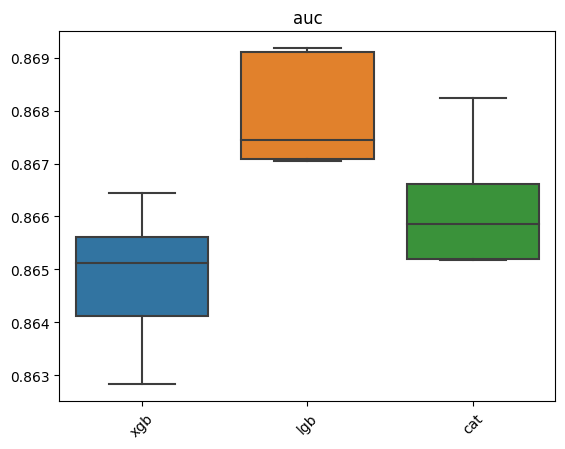

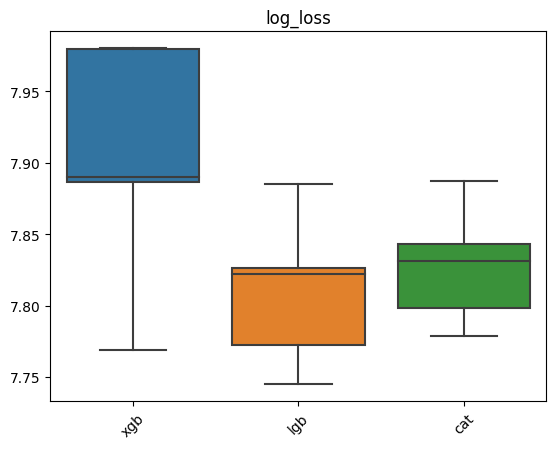

In [31]:
plot_estimators()

In [32]:
def tune_param(model, 
               param_grid, 
               refit="auc", 
               chart=None, 
               X=train_X, 
               y=train_y, cv=5):
    param_grid = {
        f"{model}__{key}" : param_grid[key]
        for key in param_grid.keys()
    }
    
    grid_cv = GridSearchCV(
        pipes[model],
        param_grid,
        scoring=metrics,
        refit=refit,
        return_train_score=True,
        cv=cv,
        n_jobs=4,
        verbose=3
    )
    
    grid_cv.fit(X, y)
    
    print(f"Best score: { grid_cv.best_score_ }")
    print(f"Best params: { grid_cv.best_params_ }")
    
    results = pd.DataFrame(grid_cv.cv_results_)
    
    if "line" in chart:
        for i, param in enumerate(param_grid.keys()):
            graph_data = results[[
                f"param_{param}",
                f"mean_test_{refit}",
                f"mean_train_{refit}"
            ]]
            
            graph_data = graph_data.rename(columns = {
                f"mean_test_{refit}" : "test",
                f"mean_train_{refit}" : "train",
            })
            
            graph_data = graph_data.melt(f"param_{param}", var_name="type", value_name=refit)
            plt.figure(i)
            plot = sns.lineplot(x=f"param_{param}", y=refit, hue="type", data=graph_data)
    
    if "heatmap" in chart:
        param1 = list(param_grid.keys())[0]
        param2 = list(param_grid.keys())[1]
        
        graph_data = results[[
            f"param_{param1}",
            f"param_{param2}",
            f"mean_test_{refit}"
        ]]
        
        graph_data = graph_data.pivot(index=f"param_{param1}", 
                                      columns=f"param_{param2}", 
                                     values=f"mean_test_{refit}")
        
        sns.heatmap(graph_data, annot=True, xticklabels=True, yticklabels=True).set(
            xlabel=param2,
            ylabel=param1
        )

Tuning CatBoostingClassifier

In [33]:
# param_grid = {
#     'depth': [i for i in range(4, 11)],
# }
# tune_param('cat', param_grid, chart="line")

In [34]:
# pipes["cat"].set_params(**{
#     "cat__depth": 6,
# })

In [35]:
# param_grid = {
#     'l2_leaf_reg': [i for i in range(2, 11, 1)],
# }
# tune_param('cat', param_grid, chart="line")

In [36]:
# pipes["cat"].set_params(**{
#     "cat__min_child_samples": 500,
# })

Tuning LGBM

In [37]:
# pipes['lgb'].named_steps['lgb'].get_params()

In [38]:
# param_grid = {
#     'min_child_samples': [i for i in range(10, 110, 10)],
# }
# tune_param('lgb', param_grid, chart="line")

In [39]:
# pipes["lgb"].set_params(**{
#     "lgb__min_child_samples": 70,
# })

In [40]:
# param_grid = {
#     'n_estimators': [i for i in range(100, 1000, 100)],
# }
# tune_param('lgb', param_grid, chart="line")

In [41]:
# pipes["lgb"].set_params(**{
#     "lgb__n_estimators": 700,
# })

In [42]:
# param_grid = {
#     'boosting_type': ["gbdt", "dart", "goss"],
# }
# tune_param('lgb', param_grid, chart="line")

Tuning XGBClassifier

In [43]:
# pipes['xgb'].named_steps['xgb'].get_params()

In [44]:
# param_grid = {
#     'n_estimators': [i for i in range(10, 110, 10)],
# }
# tune_param('xgb', param_grid, chart="line")

Plotting learning curve

In [45]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Plotting xgb
Plotting lgb
Plotting cat
928:	learn: 0.4278814	total: 2m 48s	remaining: 12.9s
929:	learn: 0.4278603	total: 2m 48s	remaining: 12.7s
930:	learn: 0.4278351	total: 2m 48s	remaining: 12.5s
931:	learn: 0.4278213	total: 2m 48s	remaining: 12.3s
932:	learn: 0.4278029	total: 2m 48s	remaining: 12.1s
933:	learn: 0.4277895	total: 2m 49s	remaining: 12s
934:	learn: 0.4277665	total: 2m 49s	remaining: 11.8s
935:	learn: 0.4277419	total: 2m 49s	remaining: 11.6s
936:	learn: 0.4277224	total: 2m 49s	remaining: 11.4s
937:	learn: 0.4277100	total: 2m 49s	remaining: 11.2s
938:	learn: 0.4276911	total: 2m 49s	remaining: 11s
939:	learn: 0.4276710	total: 2m 50s	remaining: 10.9s
940:	learn: 0.4276531	total: 2m 50s	remaining: 10.7s
941:	learn: 0.4276340	total: 2m 50s	remaining: 10.5s
942:	learn: 0.4276116	total: 2m 50s	remaining: 10.3s
943:	learn: 0.4275819	total: 2m 50s	remaining: 10.1s
944:	learn: 0.4275642	total: 2m 51s	remaining: 9.96s
945:	learn: 0.4275500	total: 2m 51s	remaining: 9.77s
946:	learn:

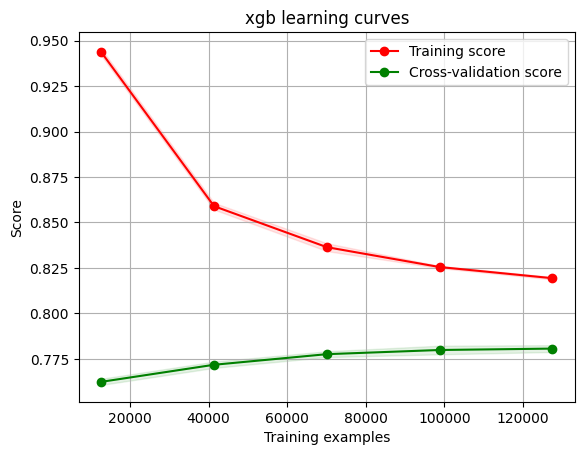

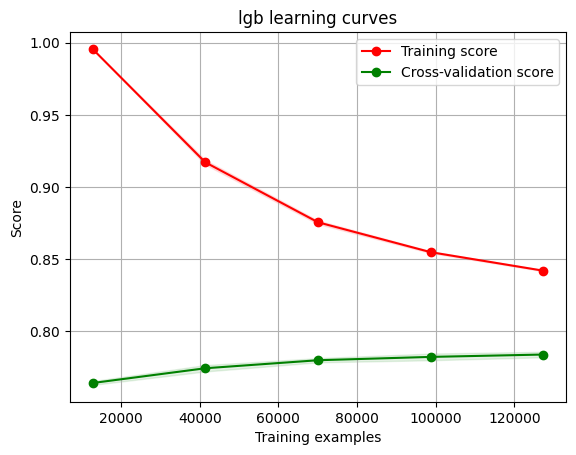

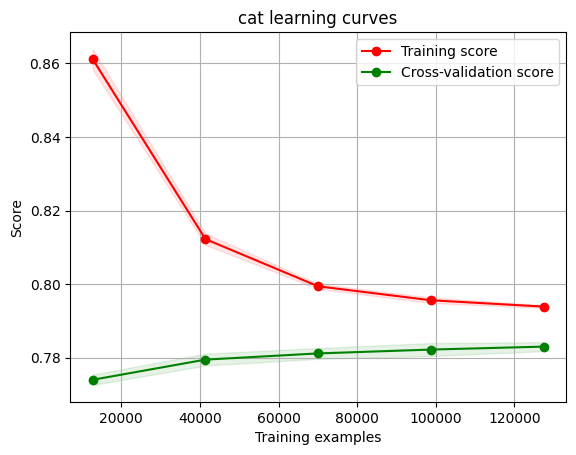

In [46]:
to_plot = [
    "xgb",
    "lgb",
#     "extree",
#     "gb",
#     "lr",
    "cat"
]

for name in pipes.keys():
    if name in to_plot:
        print(f"Plotting {name}")
        g = plot_learning_curve(
            pipes[name].named_steps[name],
            f"{name} learning curves",
            train_X_std,
            train_y,
            cv=KFold(5),
            n_jobs=4
        )

<Axes: >

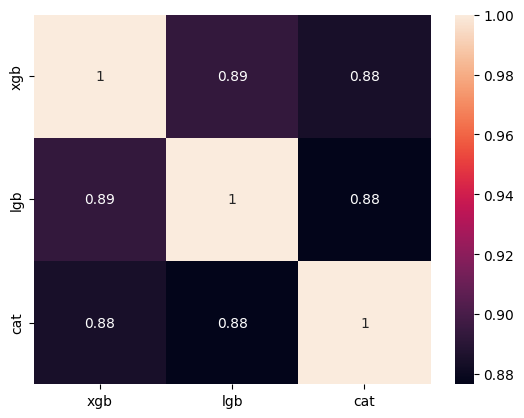

In [47]:
ensemble_results = pd.DataFrame()

for name, pipe in pipes.items():
    ensemble_results[name] = pipe.predict(train_X)
    
sns.heatmap(ensemble_results.corr(), annot=True)

## Voting

In [48]:
vote = Pipeline([
    ("std_scaler", StandardScaler()),
    ("voter", VotingClassifier(estimators, 
                               voting="soft", 
                               n_jobs=4))
], verbose=True)

In [49]:
vote.fit(train_X, train_y)

[Pipeline] ........ (step 1 of 2) Processing std_scaler, total=   0.1s
965:	learn: 0.4261334	total: 2m 5s	remaining: 4.42s
966:	learn: 0.4261192	total: 2m 5s	remaining: 4.28s
967:	learn: 0.4260930	total: 2m 5s	remaining: 4.15s
968:	learn: 0.4260649	total: 2m 5s	remaining: 4.02s
969:	learn: 0.4260544	total: 2m 5s	remaining: 3.89s
970:	learn: 0.4260295	total: 2m 5s	remaining: 3.76s
971:	learn: 0.4260054	total: 2m 5s	remaining: 3.63s
972:	learn: 0.4259875	total: 2m 6s	remaining: 3.5s
973:	learn: 0.4259678	total: 2m 6s	remaining: 3.37s
974:	learn: 0.4259482	total: 2m 6s	remaining: 3.24s
975:	learn: 0.4259283	total: 2m 6s	remaining: 3.11s
976:	learn: 0.4259274	total: 2m 6s	remaining: 2.98s
977:	learn: 0.4259041	total: 2m 6s	remaining: 2.85s
978:	learn: 0.4258824	total: 2m 6s	remaining: 2.71s
979:	learn: 0.4258557	total: 2m 6s	remaining: 2.58s
980:	learn: 0.4258255	total: 2m 6s	remaining: 2.45s
981:	learn: 0.4258024	total: 2m 6s	remaining: 2.32s
982:	learn: 0.4257902	total: 2m 6s	remaining: 

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('voter',
                 VotingClassifier(estimators=[('xgb',
                                               XGBClassifier(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             colsample_bytree=None,
                                                             early_stopping_rounds=None,
                                                             enable_categorical=False,
                                                             eval_metric=None,
                                                             feature_types=None,
                                                             gamma=None,
                                                             gpu_id=None,
                                                             grow_policy=None,
                                                             impo...
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             n_estimators=100,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             predictor=None,
                                                             random_state=None, ...)),
                                              ('lgb',
                                               LGBMClassifier(min_child_samples=70,
                                                              n_estimators=700)),
                                              ('cat',
                                               <catboost.core.CatBoostClassifier object at 0x7ee447a279d0>)],
                                  n_jobs=4, voting='soft'))],
         verbose=True)

In [50]:
pred_probs = vote.predict_proba(test_df)[:, 1]

In [51]:
pred_probs

array([0.59147911, 0.25672777, 0.44320135, ..., 0.41710129, 0.09603087,
       0.03103373])

In [52]:
submission_df = pd.DataFrame({
    "id": test_id,
    "defects": pred_probs
})

submission_df

,id,defects
0,159256,0.591479
1,159257,0.256728
2,159258,0.443201
3,159259,0.014358
4,159260,0.627409
...,...,...
106166,265422,0.589778
106167,265423,0.576782
106168,265424,0.417101
106169,265425,0.096031


In [53]:
submission_df.to_csv("submission.csv", index=False)